# `AbsorptionModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `AbsorptionModel` model. `AbsorptionModel` models 21-cm optical depth spectra like those obtained from typical HI absorption observations.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b0+0.g8f8b122.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `AbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"absorption"`.

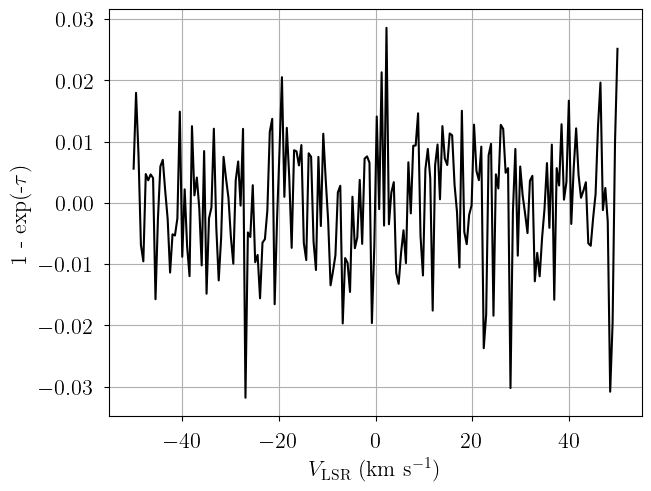

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.01 # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = rms * np.random.randn(len(velo_axis))

dummy_data = {"absorption": SpecData(
    velo_axis,
    absorption,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"1 - exp(-$\tau$)",
)}

# Plot dummy data
fig, ax = plt.subplots(layout="constrained")
ax.plot(dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-")
ax.set_xlabel(dummy_data["absorption"].xlabel)
_ = ax.set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = AbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_absorption=0.1,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.0, 20.0, 20.5]),
    "log10_depth": np.array([1.5, 0.25, 1.0]),
    "log10_pressure": np.array([3.5, 3.5, 3.5]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.1,
    "larson_power": 0.3,
    "rms_absorption": rms,
    "baseline_absorption_norm": np.array([0.0]),
}
absorption = model.model["absorption"].eval(sim_params)
data = {"absorption": SpecData(
    velo_axis,
    absorption,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"1 - exp(-$\tau$)",
)}

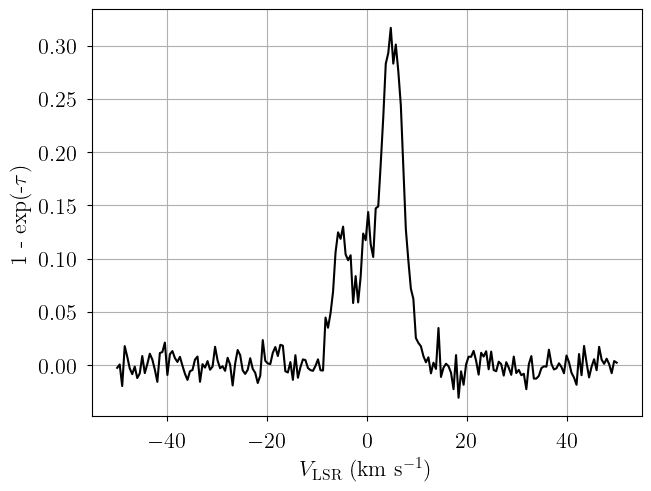

In [5]:
# Plot data
fig, ax = plt.subplots(layout="constrained")
ax.plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
ax.set_xlabel(data["absorption"].xlabel)
_ = ax.set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `AbsorptionModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = AbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_absorption=0.1,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

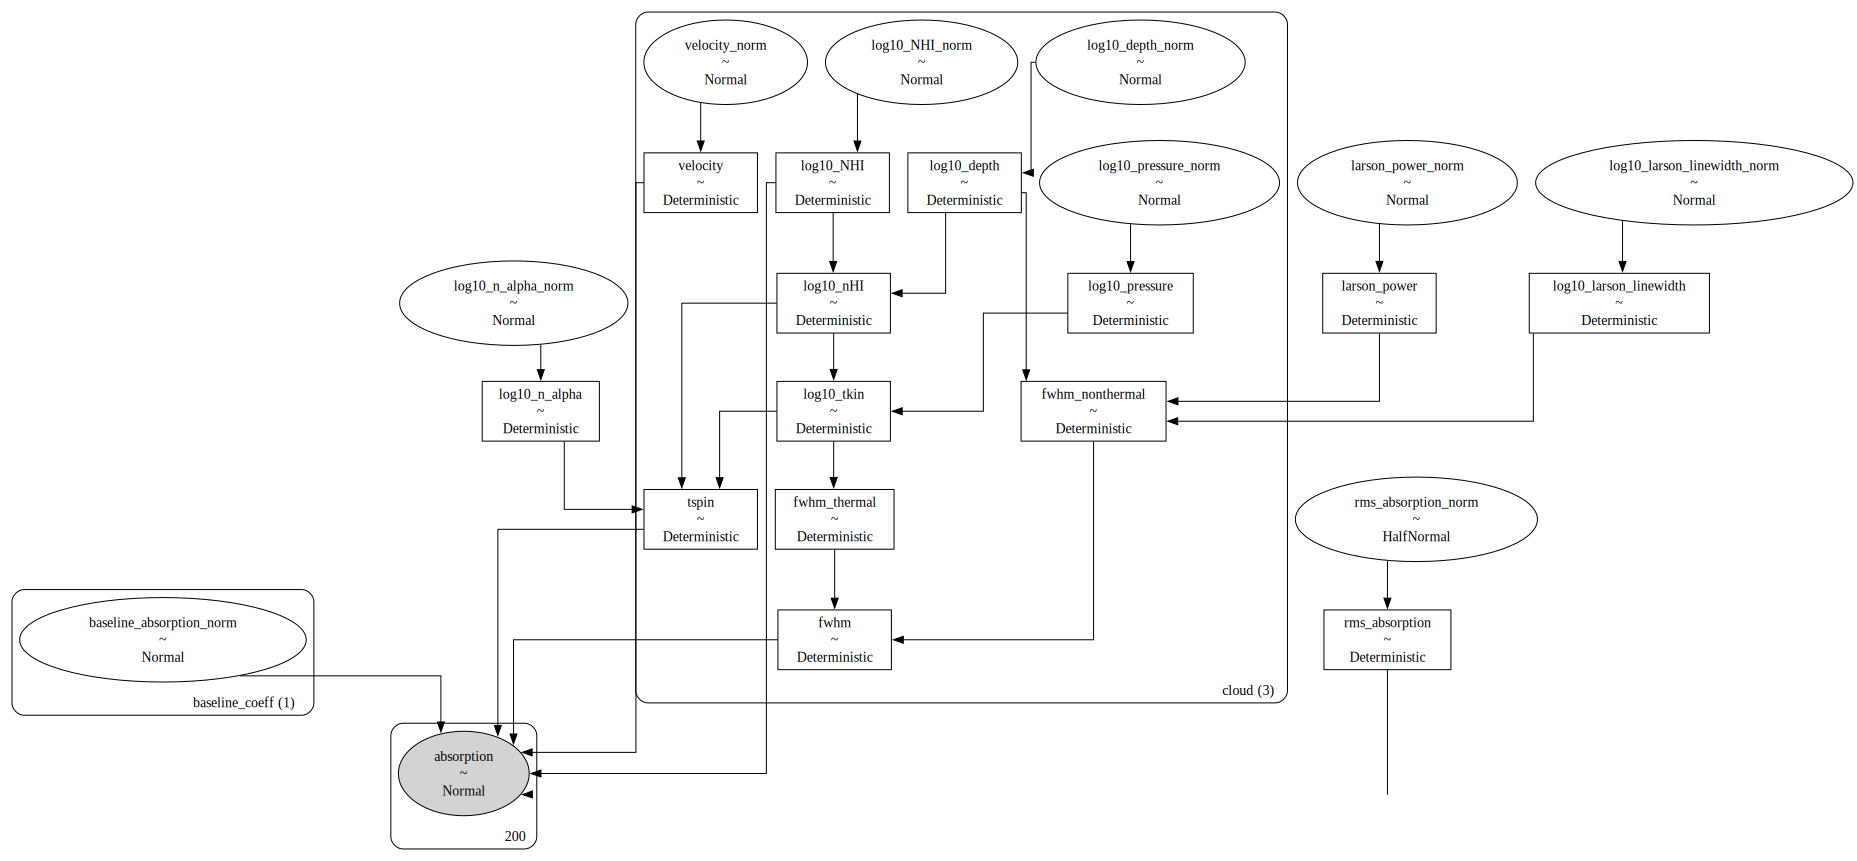

In [7]:
# Plot model graph
model.graph().render('absorption_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

   baseline_absorption_norm ~ Normal(0, 1)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
        log10_pressure_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
        rms_absorption_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
             log10_pressure ~ Deterministic(f(log10_pressure_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
                  log10_nHI ~ Deterministic(f(log10_depth_norm, log10_NHI_norm))
                 log10_tkin ~ Deterministic(f(log10_pressure_

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_pressure_norm, rms_absorption_norm, velocity_norm]


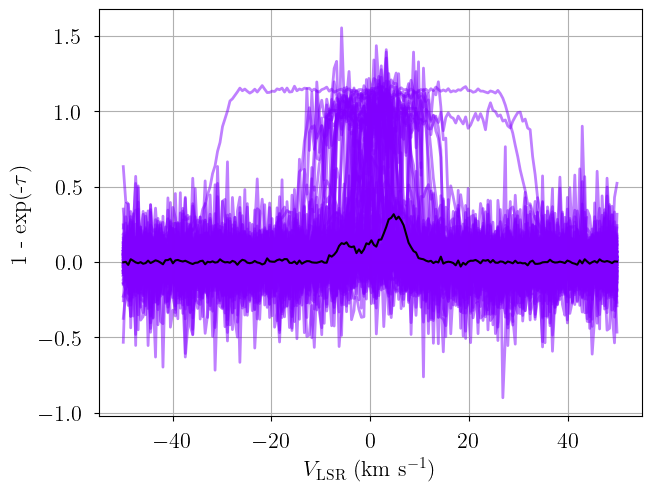

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 9600
Interrupted at 9,599 [9%]: Average Loss = -229.79


Output()

Runtime: 0.45 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.314,0.034,-0.383,-0.257,0.001,0.001,949.0,944.0,NaN
fwhm[0],6.054,0.477,5.126,6.856,0.015,0.011,980.0,917.0,NaN
fwhm[1],24.289,30.558,1.378,68.027,1.000,0.707,966.0,906.0,NaN
fwhm[2],28.399,41.553,1.237,79.009,1.256,0.905,888.0,1027.0,NaN
fwhm_nonthermal[0],5.877,0.490,4.996,6.772,0.016,0.011,981.0,923.0,NaN
fwhm_nonthermal[1],11.453,9.071,0.976,27.212,0.296,0.209,963.0,956.0,NaN
fwhm_nonthermal[2],12.836,12.616,0.928,34.733,0.406,0.287,901.0,915.0,NaN
fwhm_thermal[0],1.450,0.043,1.373,1.533,0.001,0.001,1016.0,1023.0,NaN
fwhm_thermal[1],19.392,30.566,0.261,64.131,0.991,0.701,967.0,873.0,NaN
fwhm_thermal[2],22.985,41.001,0.238,72.544,1.249,0.896,834.0,958.0,NaN


Sampling: [absorption]


Output()

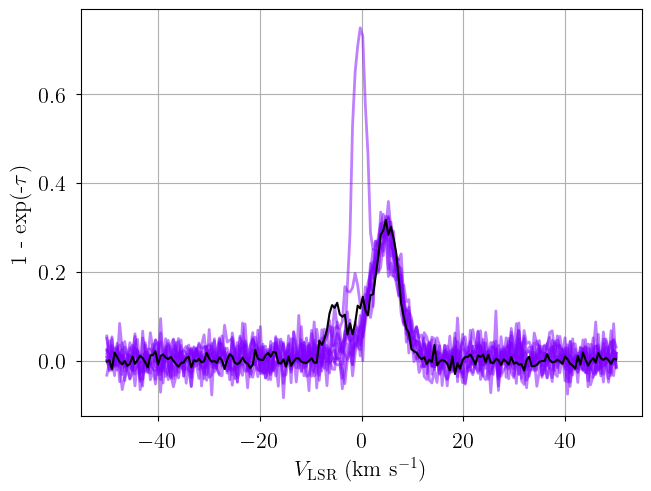

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=4,  # number of independent chains
    cores=4,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.05,
        "learning_rate": 1e-2,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9600
Interrupted at 9,599 [9%]: Average Loss = -229.79
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 816 seconds.


Adding log-likelihood to trace


Output()

There were 8 divergences in converged chains.
Runtime: 14.38 minutes


In [14]:
model.solve()

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 0 2]
Chain 1 order: [1 2 0]
Chain 2 order: [1 2 0]
Chain 3 order: [1 2 0]
Adopting (first) most common order: [1 2 0]


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_absorption_norm[0],-0.398,0.013,-0.421,-0.373,0.000,0.000,5102.0,2519.0,1.0
fwhm[0],4.988,0.127,4.756,5.232,0.002,0.001,4003.0,3345.0,1.0
fwhm[1],4.232,0.297,3.699,4.802,0.005,0.004,3535.0,3012.0,1.0
fwhm[2],2.614,0.365,2.025,3.320,0.006,0.005,3412.0,2750.0,1.0
fwhm_nonthermal[0],4.159,0.769,2.531,5.096,0.019,0.013,1804.0,1924.0,1.0
fwhm_nonthermal[1],3.150,0.791,1.674,4.500,0.018,0.013,1955.0,2279.0,1.0
fwhm_nonthermal[2],1.771,0.551,0.723,2.766,0.011,0.008,2531.0,2311.0,1.0
fwhm_thermal[0],2.436,1.037,0.739,4.380,0.025,0.018,1812.0,1773.0,1.0
fwhm_thermal[1],2.588,0.868,1.055,4.042,0.022,0.015,1612.0,2024.0,1.0
fwhm_thermal[2],1.809,0.507,0.826,2.715,0.011,0.007,2287.0,2212.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption]


Output()

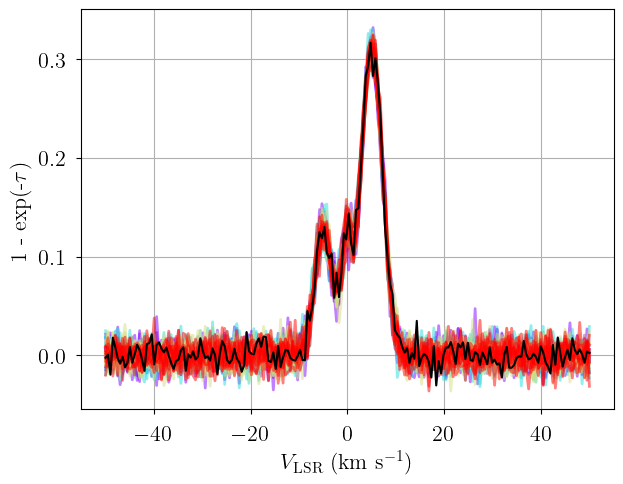

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

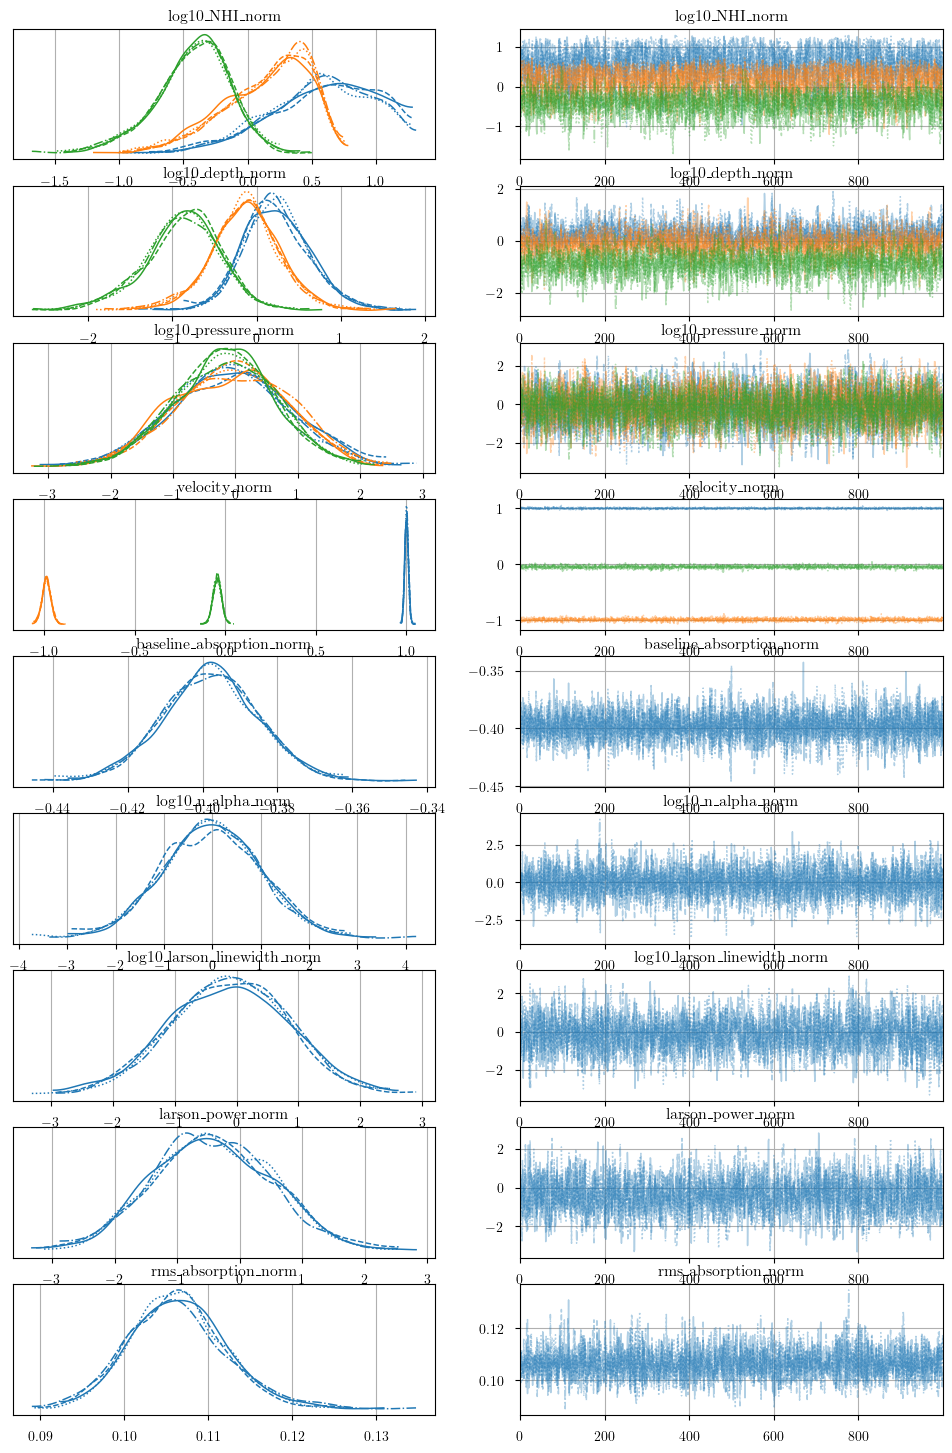

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

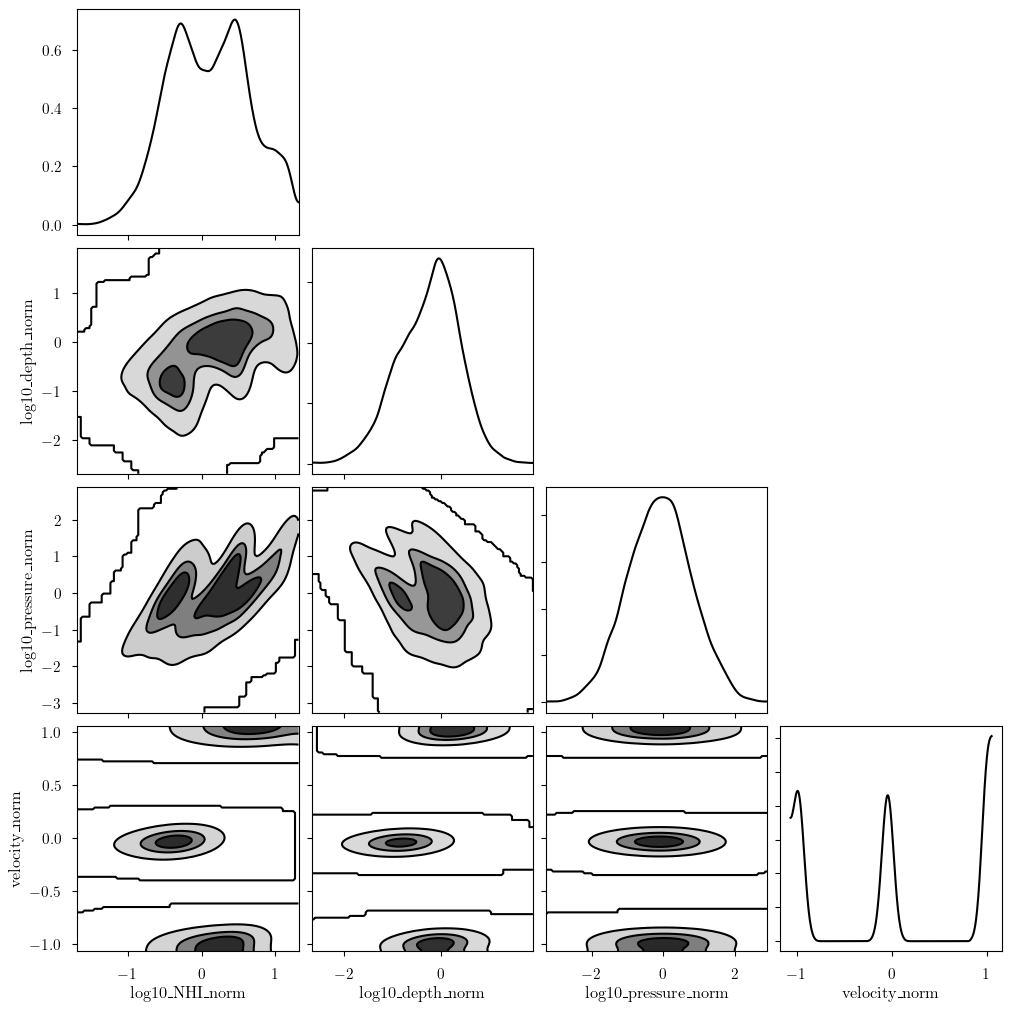

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud.

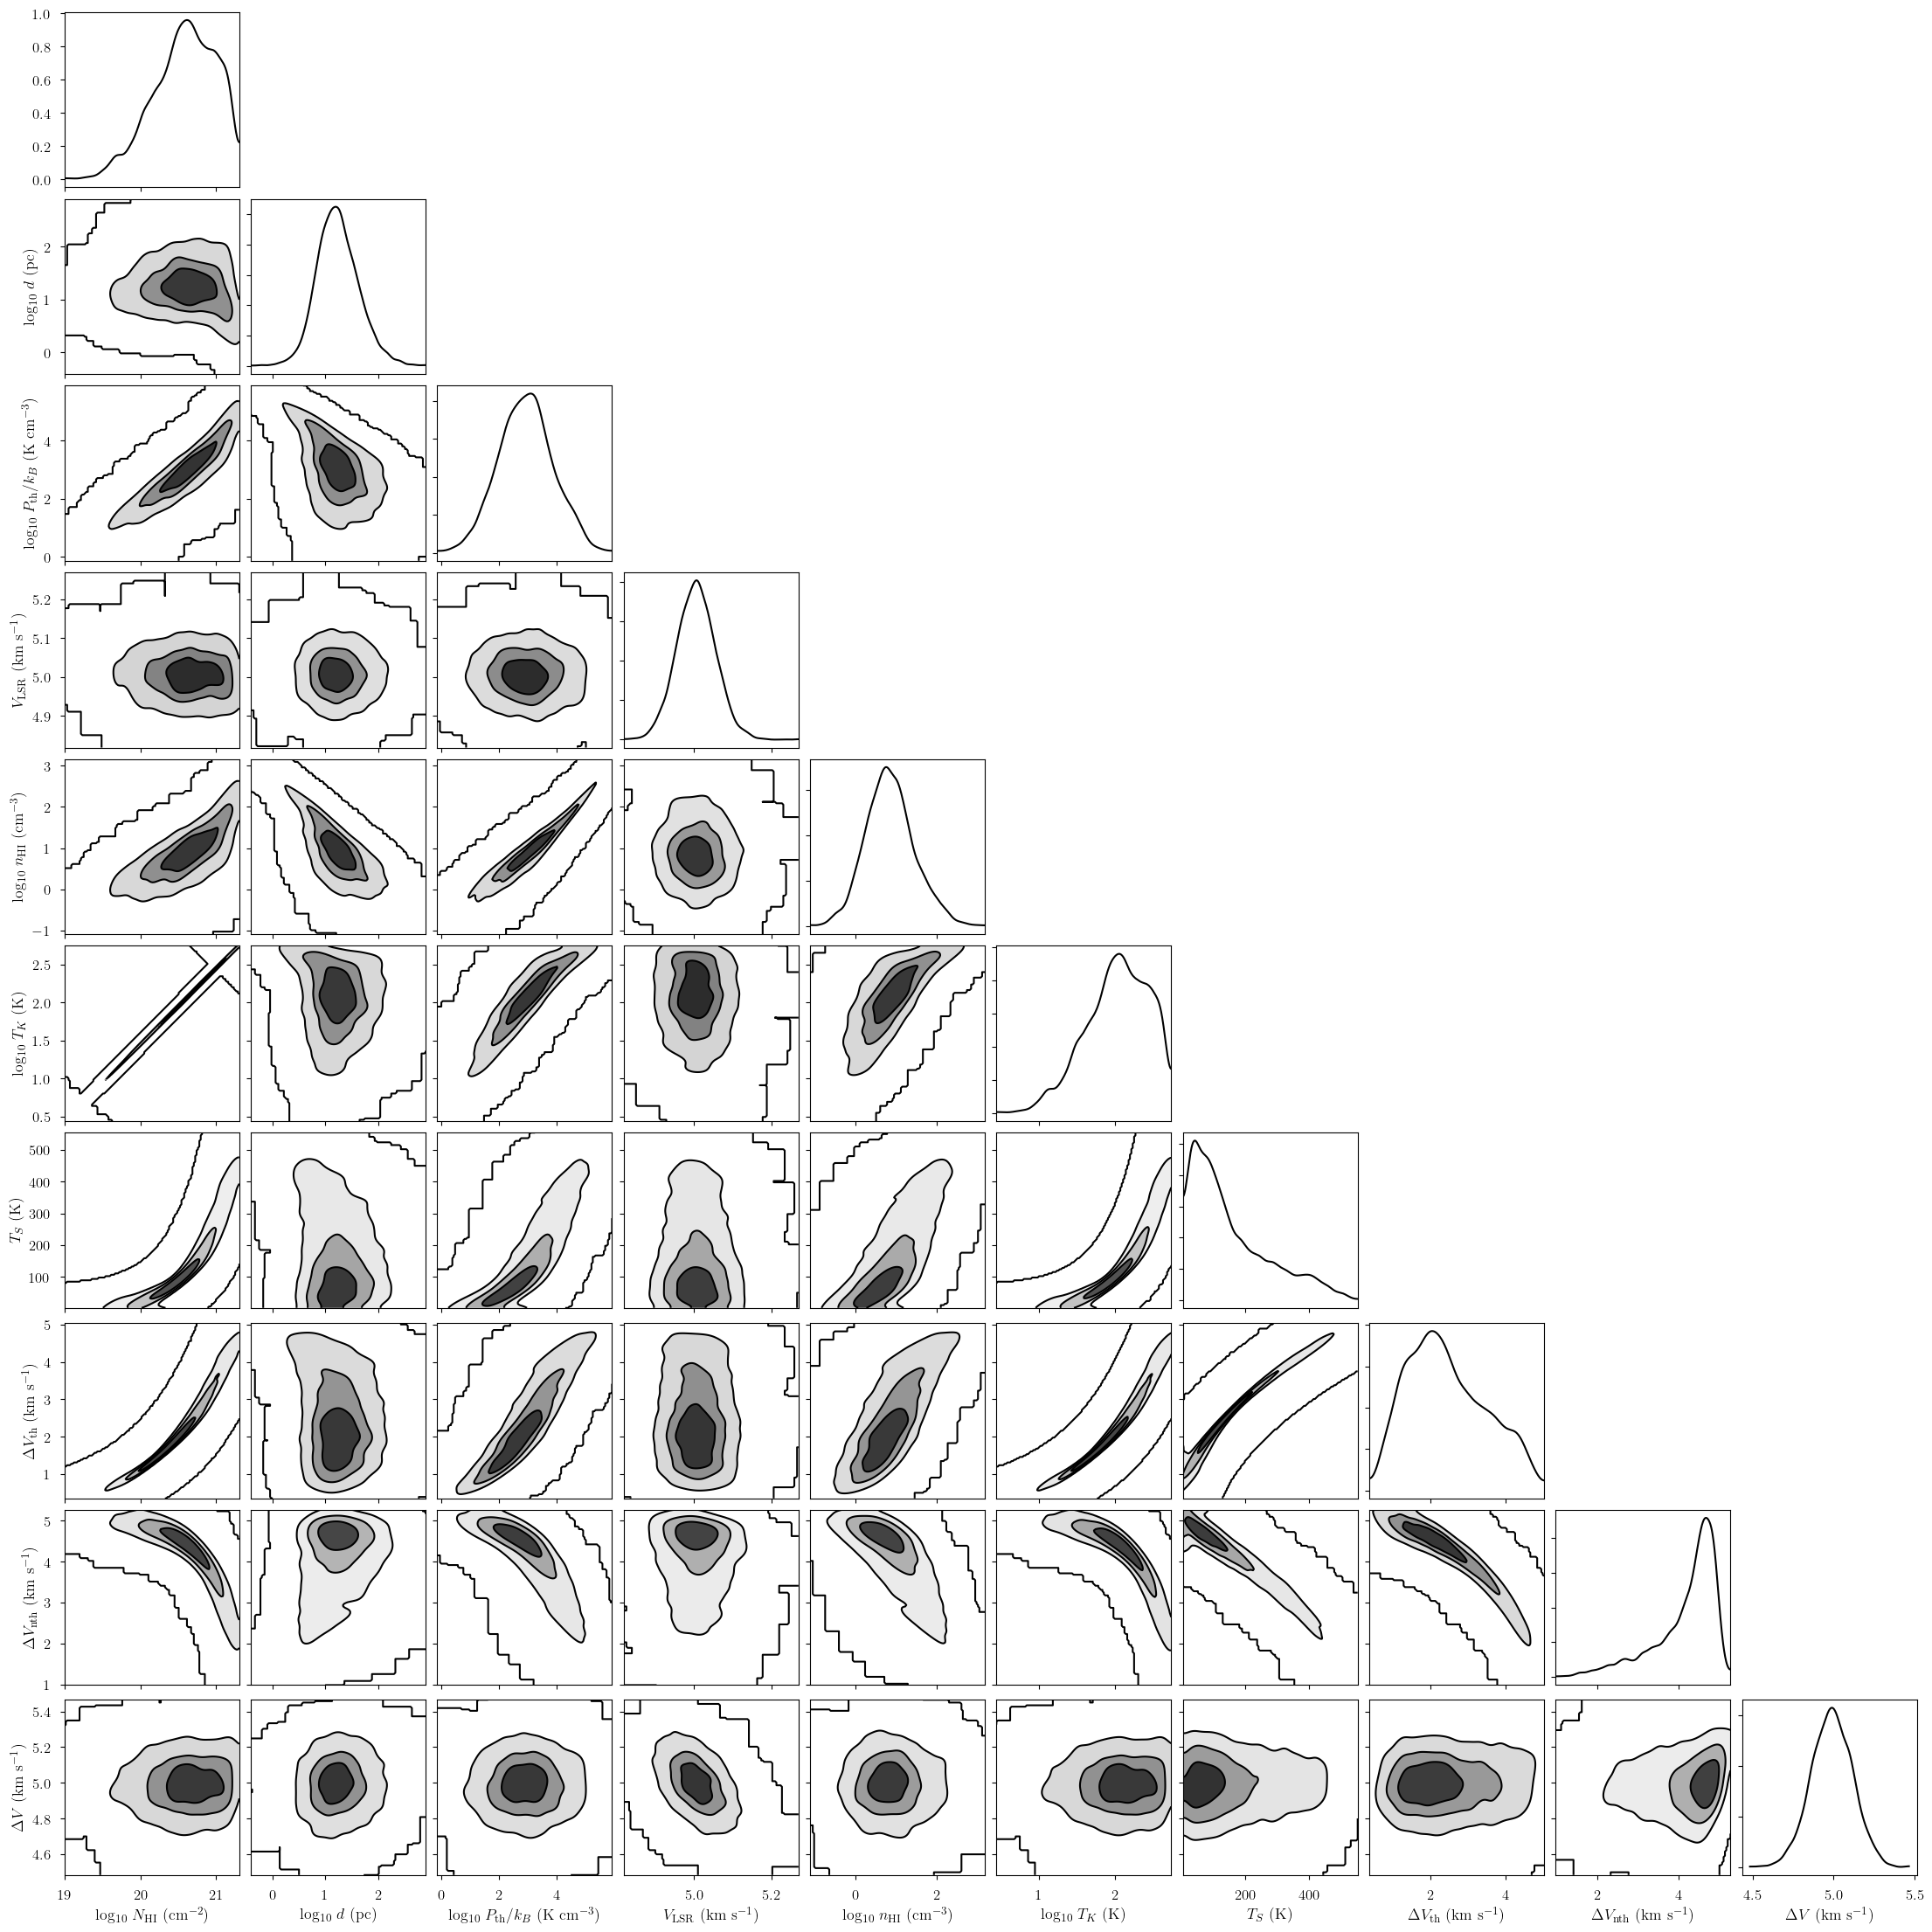

In [19]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [20]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -1160.7423796668495


,mean,sd,hdi_16%,hdi_84%
baseline_absorption_norm[0],-0.398,0.013,-0.410,-0.385
fwhm[0],4.988,0.127,4.860,5.108
fwhm[1],4.232,0.297,3.937,4.512
fwhm[2],2.614,0.365,2.191,2.855
fwhm_nonthermal[0],4.159,0.769,3.984,5.004
fwhm_nonthermal[1],3.150,0.791,2.563,4.107
fwhm_nonthermal[2],1.771,0.551,1.273,2.361
fwhm_thermal[0],2.436,1.037,1.065,3.195
fwhm_thermal[1],2.588,0.868,1.633,3.537
fwhm_thermal[2],1.809,0.507,1.255,2.264
